In [6]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2

In [16]:
function setup(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,2)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .2 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, R)
    # Actual parameters
    a = 1
    b = 0.25
    Dm = 0.01
    Dc = 5
    n = n

    p = (a, b, Dm, Dc, n, Ax, Ay, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [17]:
function simple!(dr,r,p,t)
    a, b, Dm, Dc, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*rhoT^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
end


simple! (generic function with 1 method)

In [18]:
function run(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(simple!,r0,(0.0,900),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=10)
    return sol_simp
end

run (generic function with 1 method)

In [19]:
sol = run(3)

retcode: Success
Interpolation: 1st order linear
t: 91-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
   ⋮
 820.0
 830.0
 840.0
 850.0
 860.0
 870.0
 880.0
 890.0
 900.0
u: 91-element Vector{Array{Float64, 3}}:
 [0.7336635446929285 1.670529092877866 … 4.498294423109524 4.346647867723758; 3.4924148955718612 7.197206925405183 … 8.084217249744095 9.244406861511123; … ; 8.338534481533054 3.6131523841038513 … 3.295155127929638 5.904229678435289; 9.817043479487307 3.618757071379193 … 3.1065190965909384 2.26016435978588;;; 0.14994708681109814 0.14994708681109814 … 0.14994708681109814 0.14994708681109814; 0.14994708681109814 0.14994708681109814 … 0.14994708681109814 0.14994708681109814; … ; 0.14994708681109814 0.14994708681109814 … 0.14994708681109814 0.14994708681109814; 0.14994708681109814 0.14994708681109814 … 0.14994708681109814 0.14994708681109814]
 [19.240200929112085 19.38563754275516 … 18.65342174942184 18.995728165483378; 19.072872707751

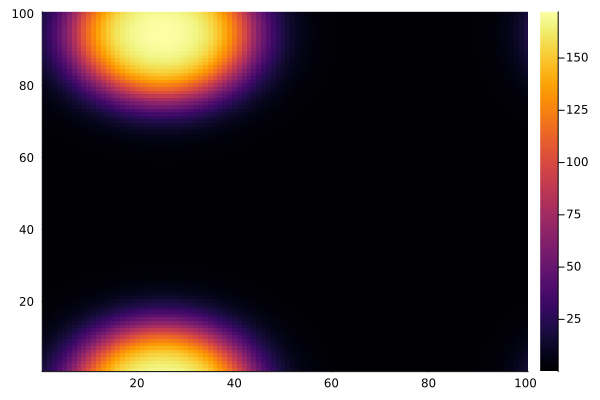

In [20]:
heatmap(sol[:,:,1,end])

In [ ]:
function setup_neg(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,5)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .1 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    r0[:,:,3] .= 0                      # PAKm
    r0[:,:,4] .= .5                    # PAKc
    r0[:,:,5] .= 0                         # PAKp
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpakm = zeros(N,N)
    Dpakc = zeros(N,N)
    Dpakp = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpakm, Dpakc, Dpakp, R)
    # Actual parameters
    a = 1
    b = 0.25
    c = .5
    d = .1 
    e = 0.1
    f = 0.01 
    g = 100.0
    k = 100 # hill constant. half-max response. 
    Dm = 0.01
    Dm2 = 0.1
    Dc = 5
    n = n

    p = (a, b, c, d, e, f, g, k, Dm, Dm2, Dc, n, Ax, Ay, dummy)
    return p, r0
end

setup_neg (generic function with 1 method)

In [447]:
function neg!(dr,r,p,t)
    a, b, c, d, e, f, g, k, Dm, Dm2, Dc, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, Dpakm, Dpakc, Dpakp, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    pakm = @view r[:,:,3]
    pakc = @view r[:,:,4]
    pakp = @view r[:,:,5]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pakm)
    mul!(tAx,pakm,Ax)
    @. Dpakm = Dm2*(Ayt + tAx)
    mul!(Ayt,Ay,pakc)
    mul!(tAx,pakc,Ax)
    @. Dpakc = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pakp)
    mul!(tAx,pakp,Ax)
    @. Dpakp = Dm2*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*rhoT^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t - g*pakp*(rhoT/(rhoT + 100))
    @. dr[:,:,2] = n*(g*pakp*(rhoT/(rhoT + 100)) - R) + D42d
    @. dr[:,:,3] = c*rhoT*pakc - d*pakm - e*(pakm+pakp)*(pakm^10 / (k^10 + pakm^10)) + Dpakm
    @. dr[:,:,4] = n*(d*pakm - c*rhoT*pakc + f*pakp) + Dpakc
    @. dr[:,:,5] = e*(pakm+pakp)*(pakm^10 / (k^10 + pakm^10)) - f*pakp + Dpakp
end


neg! (generic function with 1 method)

In [448]:
function run_neg(radius)
    p, r0 = setup_neg(radius)
    min_prob = ODEProblem(neg!,r0,(0.0,120),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=0.5)
    return sol_simp
end

run_neg (generic function with 1 method)

In [449]:
sol = run_neg(3)

retcode: Success
Interpolation: 1st order linear
t: 241-element Vector{Float64}:
   0.0
   0.5
   1.0
   1.5
   2.0
   2.5
   3.0
   3.5
   4.0
   4.5
   ⋮
 116.0
 116.5
 117.0
 117.5
 118.0
 118.5
 119.0
 119.5
 120.0
u: 241-element Vector{Array{Float64, 3}}:
 [0.7336635446929285 1.670529092877866 … 4.498294423109524 4.346647867723758; 3.4924148955718612 7.197206925405183 … 8.084217249744095 9.244406861511123; … ; 8.338534481533054 3.6131523841038513 … 3.295155127929638 5.904229678435289; 9.817043479487307 3.618757071379193 … 3.1065190965909384 2.26016435978588;;; 0.04994708681109814 0.04994708681109814 … 0.04994708681109814 0.04994708681109814; 0.04994708681109814 0.04994708681109814 … 0.04994708681109814 0.04994708681109814; … ; 0.04994708681109814 0.04994708681109814 … 0.04994708681109814 0.04994708681109814; 0.04994708681109814 0.04994708681109814 … 0.04994708681109814 0.04994708681109814;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.5 0.5 

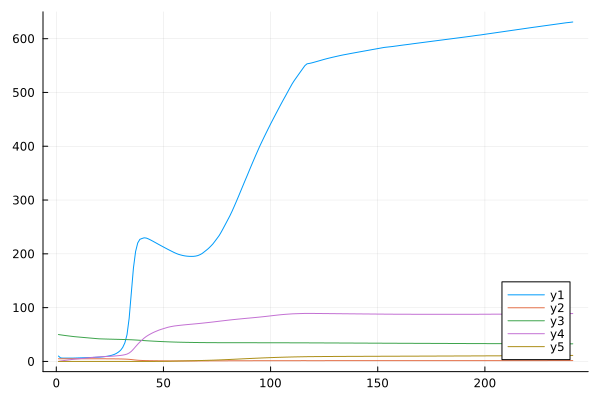

In [451]:
T = dropdims(maximum(sol[:,:,1,:], dims=(1,2)), dims = (1,2))
D = dropdims(maximum(sol[:,:,2,:], dims=(1,2)), dims = (1,2)) ./ 0.01
P = dropdims(maximum(sol[:,:,3,:], dims=(1,2)), dims = (1,2))
Pc = dropdims(mean(sol[:,:,4,:], dims=(1,2)), dims = (1,2)) ./ 0.01
Pp = dropdims(maximum(sol[:,:,5,:], dims=(1,2)), dims = (1,2)) 

plot(T)
plot!(D)
plot!(Pc)
plot!(P)
plot!(Pp, legend=:bottomright)

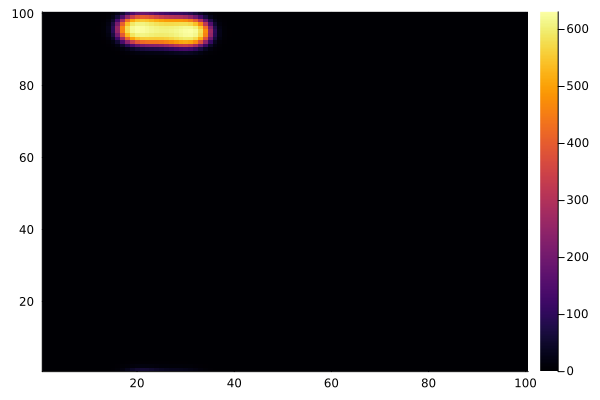

In [453]:
heatmap(sol[:,:,1,end])

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window
┌ Warning: No strict ticks found
└ @ PlotUtils /home/dinosaur/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/dinosaur/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/dinosaur/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/dinosaur/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/dinosaur/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/dinosaur/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/dinosaur/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/dinosaur/

Plots.AnimatedGif("/tmp/jl_jinGHyFG5i.gif")
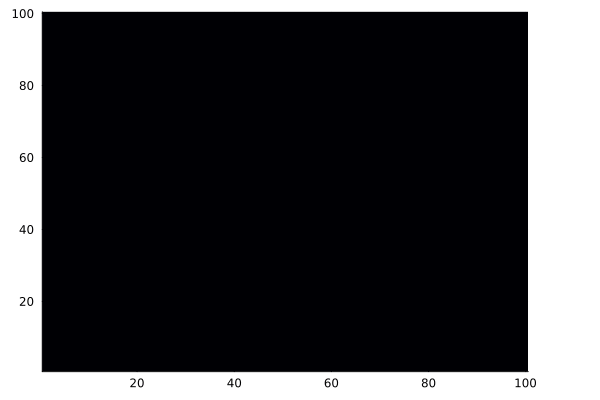

In [455]:
anim = @animate for i in 1:120
    Plots.heatmap(sol[:,:,5,i], clim=(0, maximum(sol[:,:,5,i])))
end
gif(anim, fps=5)

In [ ]:
# EXtremely cool irrelevant behavior!
# Fireworks
function setup_neg(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,5)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .2 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    r0[:,:,3] .= 0                      # PAKm
    r0[:,:,4] .= .5                    # PAKc
    r0[:,:,5] .= 0                         # PAKp
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpakm = zeros(N,N)
    Dpakc = zeros(N,N)
    Dpakp = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpakm, Dpakc, Dpakp, R)
    # Actual parameters
    a = 1
    b = 0.25
    c = .1
    d = .1
    e = 0.1
    f = 0.1 
    g = 10.0
    k = 50 # hill constant. half-max response. 
    Dm = 0.01  
    Dc = 10
    n = n

    p = (a, b, c, d, e, f, g, k, Dm, Dc, n, Ax, Ay, dummy)
    return p, r0
end

In [ ]:
# Very cool: One spot then patch split! 

function setup_neg(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,5)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .1 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    r0[:,:,3] .= 0                      # PAKm
    r0[:,:,4] .= .5                    # PAKc
    r0[:,:,5] .= 0                         # PAKp
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpakm = zeros(N,N)
    Dpakc = zeros(N,N)
    Dpakp = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpakm, Dpakc, Dpakp, R)
    # Actual parameters
    a = 1
    b = 0.25
    c = .2 # 0.1
    d = .05 # 0.1
    e = 0.1
    f = 0.1 
    g = 10.0
    k = 100 # hill constant. half-max response. 
    Dm = 0.01
    Dm2 = 0.1 #0.05
    Dc = 10
    n = n

    p = (a, b, c, d, e, f, g, k, Dm, Dm2, Dc, n, Ax, Ay, dummy)
    return p, r0
end